# Detecting Flu Epidemics via Search Engine Query Data

Flu epidemics constitute a major public health concern causing respiratory illnesses, hospitalizations, and deaths. According to the National Vital Statistics Reports published in October 2012, influenza ranked as the eighth leading cause of death in 2011 in the United States. Each year, 250,000 to 500,000 deaths are attributed to influenza related diseases throughout the world.

The U.S. Centers for Disease Control and Prevention (CDC) and the European Influenza Surveillance Scheme (EISS) detect influenza activity through virologic and clinical data, including Influenza-like Illness (ILI) physician visits. Reporting national and regional data, however, are published with a 1-2 week lag.

The [Google Flu Trends](https://www.google.org/flutrends/us/#US) project was initiated to see if faster reporting can be made possible by considering flu-related online search queries -- data that is available almost immediately.

### Understanding the Data

We would like to estimate influenza-like illness (ILI) activity using Google web search logs. Fortunately, one can easily access this data online:

ILI Data - The [CDC](http://www.cdc.gov/flu/weekly/fluactivitysurv.htm) publishes on its website the official regional and state-level percentage of patient visits to healthcare providers for ILI purposes on a weekly basis.

Google Search Queries - [Google Trends](http://www.google.com/trends/) allows public retrieval of weekly counts for every query searched by users around the world. For each location, the counts are normalized by dividing the count for each query in a particular week by the total number of online search queries submitted in that location during the week. Then, the values are adjusted to be between 0 and 1.

The csv file `FluTrain.csv` aggregates this data from January 1, 2004 until December 31, 2011 as follows:

**Week** - The range of dates represented by this observation, in year/month/day format.

**ILI** - This column lists the percentage of ILI-related physician visits for the corresponding week.

**Queries** - This column lists the fraction of queries that are ILI-related for the corresponding week, adjusted to be between 0 and 1 (higher values correspond to more ILI-related search queries).

In [1]:
# load required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Before applying analytics tools on the training set, we first need to understand the data at hand. Load `FluTrain.csv` into a data frame called FluTrain.

In [2]:
fluTrain = pd.read_csv("../Data/FluTrain.csv")
fluTrain.head()

,Week,ILI,Queries
0,2004-01-04 - 2004-01-10,2.418331,0.237716
1,2004-01-11 - 2004-01-17,1.809056,0.220452
2,2004-01-18 - 2004-01-24,1.712024,0.225764
3,2004-01-25 - 2004-01-31,1.542495,0.237716
4,2004-02-01 - 2004-02-07,1.437868,0.224436


In [3]:
fluTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 3 columns):
Week       417 non-null object
ILI        417 non-null float64
Queries    417 non-null float64
dtypes: float64(2), object(1)
memory usage: 9.9+ KB


Looking at the time period 2004-2011, which week corresponds to the highest percentage of ILI-related physician visits? Select the day of the month corresponding to the start of this week.

In [4]:
fluTrain["Week"][fluTrain["ILI"] == fluTrain["ILI"].max()]

302    2009-10-18 - 2009-10-24
Name: Week, dtype: object

Which week corresponds to the highest percentage of ILI-related query fraction?

In [5]:
fluTrain["Week"][fluTrain["Queries"] == fluTrain["Queries"].max()]

302    2009-10-18 - 2009-10-24
Name: Week, dtype: object

Let us now understand the data at an aggregate level. Plot the histogram of the dependent variable, ILI. What best describes the distribution of values of ILI?

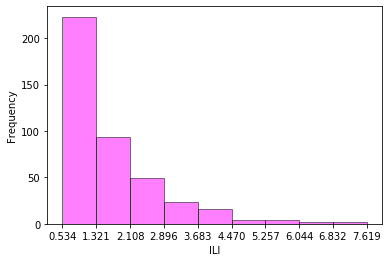

In [6]:
plt.hist(fluTrain["ILI"], 
         bins = np.linspace( min(fluTrain["ILI"]), max(fluTrain["ILI"]), 10), 
         edgecolor = "black", facecolor = "magenta", alpha = 0.5)

plt.xlabel("ILI")
plt.xticks(np.linspace( min(fluTrain["ILI"]), max(fluTrain["ILI"]), 10))
plt.ylabel("Frequency");

Most of the ILI values are small, with a relatively small number of much larger values (in statistics, this sort of data is called "skew right"). 

When handling a skewed dependent variable, it is often useful to predict the logarithm of the dependent variable instead of the dependent variable itself -- this prevents the small number of unusually large or small observations from having an undue influence on the sum of squared errors of predictive models. 

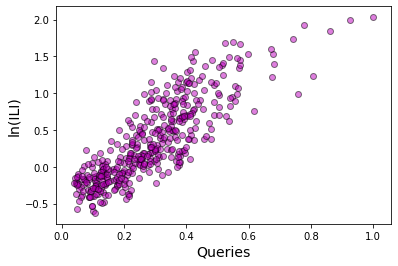

In [7]:
plt.scatter(fluTrain["Queries"], fluTrain["ILI"].apply(np.log), 
            color = "m", edgecolors = "black", alpha = 0.5)
plt.xlabel("Queries", fontsize = 14)
plt.ylabel("ln(ILI)", fontsize = 14);

### Linear Regression Model

Based on the plot we just made, it seems that a linear regression model could be a good modeling choice. 

$log(ILI) = intercept + coef*Queries$, where the coefficient is positive

In [8]:
# create a new variable
fluTrain["log_ILI"] = fluTrain["ILI"].apply(np.log)

In [9]:
# linear regression using statsmodel 
# statsmodel using formula
import statsmodels.formula.api as smf

features = ['Queries']
xTrain = fluTrain[features]
yTrain = fluTrain['log_ILI']

x = "+".join(features)
modelLR_stat = smf.ols('log_ILI ~ {}'.format(x), data = fluTrain).fit()
print(modelLR_stat.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ILI   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sun, 14 Jul 2019   Prob (F-statistic):          2.62e-113
Time:                        21:21:48   Log-Likelihood:                -87.974
No. Observations:                 417   AIC:                             179.9
Df Residuals:                     415   BIC:                             188.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4993      0.030    -16.422      0.0

For a single variable linear regression model, there is a direct relationship between the R-squared and the correlation between the independent and the dependent variables: $R^2 = r^2$, where $r$ is a correlation.

### Performance on the Test Set

The csv file `FluTest.csv` provides the 2012 weekly data of the ILI-related search queries and the observed weekly percentage of ILI-related physician visits. Load this data into a data frame called FluTest.

Normally, we would obtain test-set predictions from the linear regression model. However, the dependent variable in our model is $log(ILI)$, so we need to convert from predictions of $log(ILI)$ to predictions of ILI via exponentiation, or the exp() function.

In [10]:
fluTest = pd.read_csv("../Data/FluTest.csv")
xTest = fluTest[features]
yTest = fluTest["ILI"]

In [11]:
predictedILI = modelLR_stat.predict(xTest)
predictedILI = predictedILI.apply(np.exp)

What is our estimate for the percentage of ILI-related physician visits for the week of March 11, 2012?

In [12]:
weekFilter = fluTest["Week"] == '2012-03-11 - 2012-03-17'
predictedILI[weekFilter]

10    2.187378
dtype: float64

What is the relative error betweeen the estimate (our prediction) and the observed value for the week of March 11, 2012? 

In [13]:
(yTest[weekFilter] - predictedILI[weekFilter])/yTest[weekFilter]

10    0.046238
dtype: float64

What is the Root Mean Square Error (RMSE) between our estimates and the actual observations for the percentage of ILI-related physician visits, on the test set?

_Mean square error_ (MSE)
\begin{equation}
  MSE = \frac{1}{n}\sum_{i=1}^{n}{(y_{i}-\hat y_{i})^2}
\end{equation}

_Root Mean Square Error_ (RMSE)
\begin{equation}
  RMSE = \sqrt{MSE}
\end{equation}


In [14]:
np.sqrt(np.mean((yTest - predictedILI)**2))

0.7490645271019662

### Time series model

The observations in this dataset are consecutive weekly measurements of the dependent and independent variables. This sort of dataset is called a "time series." Often, statistical models can be improved by predicting the current value of the dependent variable using the value of the dependent variable from earlier weeks. In our models, this means we will predict the ILI variable in the current week using values of the ILI variable from previous weeks.

First, we need to decide the amount of time to lag the observations. Because the ILI variable is reported with a 1- or 2-week lag, a decision maker cannot rely on the previous week's ILI value to predict the current week's value. Instead, the decision maker will only have data available from 2 or more weeks ago. We will build a variable called ILILag2 that contains the ILI value from 2 weeks before the current observation.

In [15]:
# build a new variable that contains values of the ILI with a 2 weeks lag
fluTrain[["ILILag2"]] = fluTrain[["ILI"]].shift(periods = 2)
fluTrain[["log_ILILag2"]] = fluTrain[["ILILag2"]].apply(np.log)

There is a strong positive relationship between log(ILILag2) and log(ILI).

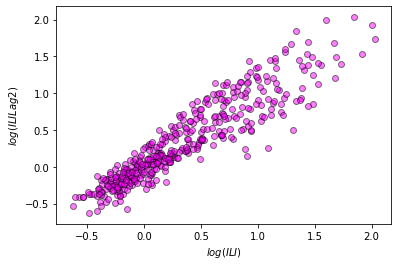

In [16]:
plt.scatter(fluTrain[["log_ILI"]], fluTrain[["log_ILILag2"]],
           color = "magenta", alpha = 0.5, edgecolor = "black")
plt.xlabel("$log(ILI)$")
plt.ylabel("$log(ILILag2)$");

Train a linear regression model on the FluTrain dataset to predict the log of the ILI variable using the Queries variable as well as the log of the ILILag2 variable.

In [17]:
# linera regression for time series model
features = ['Queries', 'log_ILILag2']
xTrain = fluTrain[features]
yTrain = fluTrain['log_ILI']

x = "+".join(features)
modelLR_time_series = smf.ols('log_ILI ~ {}'.format(x), data = fluTrain).fit()
print(modelLR_time_series.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ILI   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     1993.
Date:                Sun, 14 Jul 2019   Prob (F-statistic):          1.38e-212
Time:                        21:21:49   Log-Likelihood:                 147.24
No. Observations:                 415   AIC:                            -288.5
Df Residuals:                     412   BIC:                            -276.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2406      0.020    -12.321      

Intercept, Queries, and log_ILILag2 coefficients are significant at the p=0.05 level in this regression model. Moving from modelLR_stat to modelLR_time_series, in-sample $R^2$ improved from 0.709 to 0.9063, and the new variable is highly significant. As a result, there is no sign of overfitting, and modelLR_time_series is superior to modelLR_stat on the training set.

### Evaluating the Time Series Model in the Test Set

So far, we have only added the ILILag2 variable to the fluTrain data frame. To make predictions with our modelLR_time_series, we will also need to add ILILag2 to the fluTest data frame.

In [18]:
fluTest[["ILILag2"]] = fluTest[["ILI"]].shift(periods = 2)
fluTest[["log_ILILag2"]] = fluTest[["ILILag2"]].apply(np.log)

In this problem, the training and testing sets are split sequentially -- the training set contains all observations from 2004-2011 and the testing set contains all observations from 2012. There is no time gap between the two datasets, meaning the first observation in FluTest was recorded one week after the last observation in FluTrain.

In [19]:
print("Training Data Set")
print(fluTrain.tail())
print("\nTest Data Set")
print(fluTest.head())

Training Data Set
                        Week       ILI  ...   ILILag2  log_ILILag2
412  2011-11-27 - 2011-12-03  1.465723  ...  1.462212     0.379950
413  2011-12-04 - 2011-12-10  1.518106  ...  1.655415     0.504052
414  2011-12-11 - 2011-12-17  1.663954  ...  1.465723     0.382349
415  2011-12-18 - 2011-12-24  1.852736  ...  1.518106     0.417464
416  2011-12-25 - 2011-12-31  2.124130  ...  1.663954     0.509197

[5 rows x 6 columns]

Test Data Set
                      Week       ILI   Queries   ILILag2  log_ILILag2
0  2012-01-01 - 2012-01-07  1.766707  0.593625       NaN          NaN
1  2012-01-08 - 2012-01-14  1.543401  0.499336       NaN          NaN
2  2012-01-15 - 2012-01-21  1.647615  0.500664  1.766707     0.569117
3  2012-01-22 - 2012-01-28  1.684297  0.479416  1.543401     0.433988
4  2012-01-29 - 2012-02-04  1.863542  0.471448  1.647615     0.499329


From this, we can fill in the ILILag2 variable for the first and second observations in FluTest with the ILI value of the two last observations in the FluTrain data frame.

In [20]:
fluTest.loc[0, "log_ILILag2"] = fluTrain["log_ILI"].iloc[-2]
fluTest.loc[1, "log_ILILag2"] = fluTrain["log_ILI"].iloc[-1]

fluTest.loc[0,"ILILag2"] = fluTrain["ILI"].iloc[-2]
fluTest.loc[1, "ILILag2"] = fluTrain["ILI"].iloc[-1]

fluTest.head()


,Week,ILI,Queries,ILILag2,log_ILILag2
0,2012-01-01 - 2012-01-07,1.766707,0.593625,1.852736,0.616663
1,2012-01-08 - 2012-01-14,1.543401,0.499336,2.124130,0.753362
2,2012-01-15 - 2012-01-21,1.647615,0.500664,1.766707,0.569117
3,2012-01-22 - 2012-01-28,1.684297,0.479416,1.543401,0.433988
4,2012-01-29 - 2012-02-04,1.863542,0.471448,1.647615,0.499329


In [21]:
xTest = fluTest[features]
yTest = fluTest["ILI"]

predictedILI = modelLR_time_series.predict(xTest)
predictedILI = predictedILI.apply(np.exp)

The test-set RMSE of the time series model

In [22]:
np.sqrt(np.mean((yTest - predictedILI)**2))

0.2942028535866688

that is the best test set RSME of the two models.